In [1]:
# Import libraries
import numpy as np
import pandas as pd
import psycopg2
import getpass
import os.path
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load the database connection details
_data = np.load('data/db_details.npy', allow_pickle=True).tolist()
db_details = _data['db_details']
user = db_details['user']
host = db_details['host']
port = db_details['port']
dbname = db_details['dbname']
schema = db_details['schema']
    
# Connect to the database
conn = psycopg2.connect(dbname=dbname, user=user, host=host, port=port, password=getpass.getpass(prompt='Password:'.format(user)))
cur = conn.cursor()
cur.execute('SET search_path TO {}'.format(schema))
conn.commit()

Password: ··········


In [3]:
# Load the patient data
_data = np.load('data/patients.npy', allow_pickle=True).tolist()
patients = _data['patients']
mech_vent = _data['mech_vent']
print("Loaded!")

Loaded!


In [4]:
# Show some sample mechanical ventilation data
mech_vent.head()

,icustay_id,ventnum,starttime,endtime,duration_hours
17,200045.0,4,2116-07-17 17:00:00,2116-07-29 07:00:00,278.000000
25,200059.0,4,2198-02-18 22:35:00,2198-02-19 07:00:00,8.416667
32,200063.0,4,2141-03-31 11:21:00,2141-03-31 17:58:00,6.616667
82,200220.0,4,2148-01-25 18:00:00,2148-02-12 13:40:00,427.666667
127,200343.0,4,2116-09-15 19:10:00,2116-09-16 03:00:00,7.833333


In [5]:
# Initialise place to store results
result = np.zeros((6,))

# Loop over every patient
for icustay_id in np.unique(mech_vent['icustay_id']):
    
    # Select data for one individual patient
    data = np.array(mech_vent[mech_vent['icustay_id']==icustay_id])
    
    # Calculate how many times that patient has been intubated
    max_ventnum = max(data[:,1])

    # Initialise a list to append results to
    patient_list = []

    # Loop over every instance of ventilation for that patient
    for i in range(max_ventnum):
    
        previous_vent = data[i,(0,1,3)] # icustay_id, and previous ventilation number and end time
    
        # Account for cases where there is no re-intubation
        try:
            subsequent_vent = data[i+1,(1,2)] # subsesequent ventilation number and start time
            time_diff = (subsequent_vent[-1] - previous_vent[-1]).total_seconds()/(60*60) # calculates time between extubation and re-intubation in hours
        except:
            subsequent_vent = np.zeros((2,))
            time_diff = 0.0
    
        # Append result to a list for this patient
        patient_list.append(np.concatenate([previous_vent, subsequent_vent, [time_diff]]))

    # Convert patient list to numpy array and append to other results
    patient_list = np.array(patient_list)
    result = np.vstack((result, patient_list))

# Convert result array to pandas DataFrame
ri_times = pd.DataFrame(result[1:], columns=['icustay_id', 'ventprev', 'endtime', 'ventsub', 'starttime', 'timediff'])

# Show some sample data
ri_times.head()

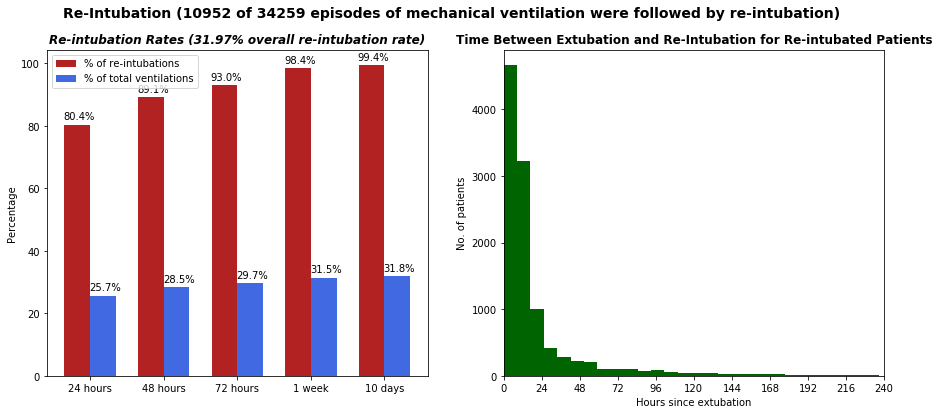

In [47]:
# Calculate statistics on re-intubation
n = len(ri_times)
re_int = n - sum(ri_times['timediff']==0)
ri_patients = ri_times[ri_times['timediff']>0]
_24h = len(ri_patients[ri_patients['timediff']<=24])
_48h = len(ri_patients[ri_patients['timediff']<=48])
_72h = len(ri_patients[ri_patients['timediff']<=72])
_7d = len(ri_patients[ri_patients['timediff']<=168])
_10d = len(ri_patients[ri_patients['timediff']<=240])

# Visualise re-intubation rates and re-intubation times
fig, axs = plt.subplots(1, 2, figsize=(15,6))
fig.suptitle('Re-Intubation ({} of {} episodes of mechanical ventilation were followed by re-intubation)'.format(re_int, n), weight='semibold', fontsize=14)

# Plot the re-intubation rates
reintubations = [
    100 * _24h / len(ri_patients),
    100 * _48h / len(ri_patients),
    100 * _72h / len(ri_patients),
    100 * _7d / len(ri_patients),
    100 * _10d / len(ri_patients)
]
overalls = [
    100 * _24h / len(ri_times),
    100 * _48h / len(ri_times),
    100 * _72h / len(ri_times),
    100 * _7d / len(ri_times),
    100 * _10d / len(ri_times)
]
labels = ['24 hours', '48 hours', '72 hours', '1 week', '10 days']
x = np.arange(len(labels))
width = 0.35
bar1 = axs[0].bar(x - width/2, reintubations, width, label='% of re-intubations', color='firebrick')
bar2 = axs[0].bar(x + width/2, overalls, width, label='% of total ventilations', color='royalblue')
axs[0].set_title('Re-intubation Rates ({:.2f}% overall re-intubation rate)'.format(100*re_int/n), style='italic', weight='semibold')
axs[0].set_xticks(x)
axs[0].set_xticklabels(labels)
axs[0].set_ylabel('Percentage')
axs[0].legend()

# Add a text label above bars in bar chart
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        axs[0].annotate('{:.1f}%'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(2, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(bar1)
autolabel(bar2)

# Plot the re-intubation times
axs[1].hist(x=ri_patients['timediff'], bins=200, color='darkgreen')
axs[1].set_title('Time Between Extubation and Re-Intubation for Re-intubated Patients', weight='semibold')
axs[1].set_xlim([0,240])
axs[1].set_xticks(range(0,241,24))
axs[1].set_xlabel('Hours since extubation')
axs[1].set_ylabel('No. of patients')

# Save plot
plt.savefig('plots/reintubation.png');

In [ ]:
# Save to re_intubation.npy
if not os.path.exists('./data'):
    os.makedirs('./data')

tosave = {'re_intubation': ri_times}
np.save('data/re_intubation.npy',tosave)
print("Saved!")